In [1]:
import numpy as np


from glob import glob
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix
from torchmetrics import Accuracy, Precision, Recall, F1Score
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, random_split, Dataset
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.models as models

from transformers import ViTImageProcessor, ViTForImageClassification
from transformers import AutoImageProcessor, AutoModelForImageClassification
from torch.autograd import Variable
import torch.nn.functional as F
from transformers import ViTModel





import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix

from warnings import filterwarnings
filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
!pip install timm # kaggle doesnt have it installed by default
import timm
from timm.loss import LabelSmoothingCrossEntropy

### GPU Availability

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device : {device}')

Using device : cuda


### Data Augmentation

In [4]:
imgSize = (224, 224)

transformer = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

valTransformer = transforms.Compose([
    transforms.Resize(imgSize),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Loading Dataset

In [5]:
def get_classes(data_dir):
    all_data = datasets.ImageFolder(data_dir)
    return all_data.classes

path = '/kaggle/input/melanoma-cancer-dataset/train'
valPath = '/kaggle/input/melanoma-cancer-dataset/test'

trainData = datasets.ImageFolder(root = path, transform = transformer)
valData = datasets.ImageFolder(root = valPath, transform = valTransformer)
classes = get_classes(path)
classes

['Benign', 'Malignant']

In [6]:
# Data loaders
batchSize = 256

trainLoader = DataLoader(trainData, batch_size = batchSize, shuffle = True, num_workers = 4)
valLoader = DataLoader(valData, batch_size = batchSize, shuffle = False, num_workers = 4)

# Defining Model

In [7]:
model = torch.hub.load('facebookresearch/deit:main', 'deit_tiny_patch16_224', pretrained=True)


num_ftrs = model.head.in_features
model.head = nn.Linear(num_ftrs, 1)  


Downloading: "https://github.com/facebookresearch/deit/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/deit/deit_tiny_patch16_224-a1311bcf.pth" to /root/.cache/torch/hub/checkpoints/deit_tiny_patch16_224-a1311bcf.pth
100%|██████████| 21.9M/21.9M [00:00<00:00, 102MB/s] 


### Data Parallelism

In [8]:
# Defining the loss, optimizer, and annealer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
scheduler = ReduceLROnPlateau(optimizer, threshold = 0.01, factor = 0.1, patience = 3, min_lr = 1e-5, verbose = True)

### Early Stopping

In [9]:
patience = 5
minDelta = 0.01
currentPatience = 0
bestLoss = float('inf')

# Training Model

In [10]:
model.to(device)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()


In [11]:
scaler = GradScaler()

# Lists to store training and validation metrics
trainLosses = []
valLosses = []
valAccs = []

# Training loop
epochs = 15

for epoch in range(epochs):
    # Training phase
    model.train()
    runningLoss = 0.0

    for inputs, labels in trainLoader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.unsqueeze(1).float()

        optimizer.zero_grad()

        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        runningLoss += loss.item()

    trainLoss = runningLoss / len(trainLoader)
    print(f'Epoch {epoch + 1}/{epochs} - Training Loss : {trainLoss:.2f}')
    trainLosses.append(trainLoss)

    # Validation phase
    model.eval()
    with torch.no_grad():
        valLoss = 0.0
        correct = total = 0

        for inputs, labels in valLoader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.unsqueeze(1).float()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valLoss += loss.item()

            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avgLoss = valLoss / len(valLoader)
        accuracy = correct / total * 100

        print(f'Validation Loss : {avgLoss:.2f} Validation Accuracy : {accuracy:.2f}%\n')
        valLosses.append(avgLoss)
        valAccs.append(accuracy)

        # Early stopping
        if avgLoss < bestLoss - minDelta:
            bestLoss = avgLoss
            currentPatience = 0
        else:
            currentPatience += 1

        scheduler.step(avgLoss)

Epoch 1/15 - Training Loss : 0.58
Validation Loss : 0.55 Validation Accuracy : 72.95%

Epoch 2/15 - Training Loss : 0.38
Validation Loss : 0.35 Validation Accuracy : 85.75%

Epoch 3/15 - Training Loss : 0.35
Validation Loss : 0.30 Validation Accuracy : 88.45%

Epoch 4/15 - Training Loss : 0.31
Validation Loss : 0.31 Validation Accuracy : 87.70%

Epoch 5/15 - Training Loss : 0.29
Validation Loss : 0.26 Validation Accuracy : 91.90%

Epoch 6/15 - Training Loss : 0.27
Validation Loss : 0.33 Validation Accuracy : 85.90%

Epoch 7/15 - Training Loss : 0.27
Validation Loss : 0.35 Validation Accuracy : 85.10%

Epoch 8/15 - Training Loss : 0.26
Validation Loss : 0.27 Validation Accuracy : 90.30%

Epoch 9/15 - Training Loss : 0.24
Validation Loss : 0.20 Validation Accuracy : 92.80%

Epoch 10/15 - Training Loss : 0.24
Validation Loss : 0.37 Validation Accuracy : 82.50%

Epoch 11/15 - Training Loss : 0.23
Validation Loss : 0.26 Validation Accuracy : 88.95%

Epoch 12/15 - Training Loss : 0.23
Valida

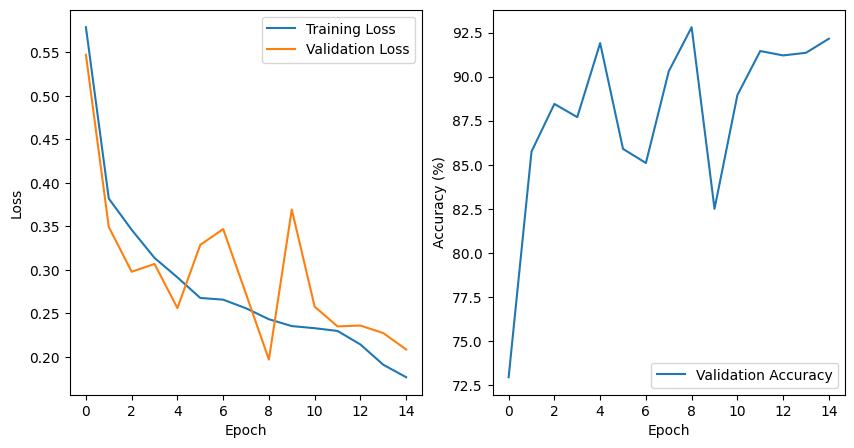

In [12]:
# Plotting training and validation metrics
plt.figure(figsize = (10, 5))

plt.subplot(1, 2, 1)
plt.plot(trainLosses, label = 'Training Loss')
plt.plot(valLosses, label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(valAccs, label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

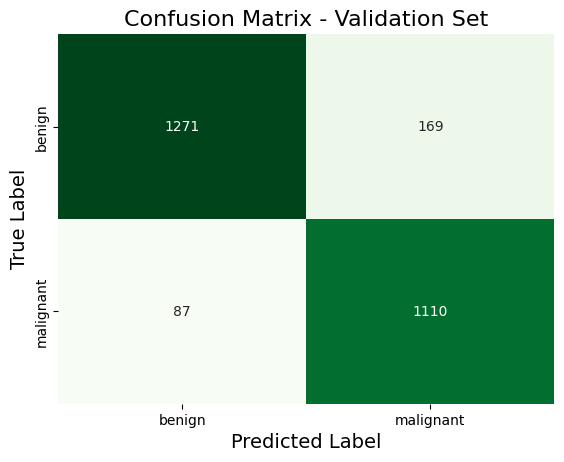

In [13]:
testt_path = "/kaggle/input/skin-cancer-malignant-vs-benign/train"

testt_data = datasets.ImageFolder(root = testt_path, transform = valTransformer)

testtLoader = DataLoader(testt_data, batch_size = batchSize, shuffle = False, num_workers = 4)
model.eval()
allLabels = []
allPreds = []

with torch.no_grad():
    for inputs, labels in testtLoader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.unsqueeze(1).float()

        outputs = model(inputs)
        predictions = (torch.sigmoid(outputs) > 0.5).float()

        allLabels.extend(labels.cpu().numpy())
        allPreds.extend(predictions.cpu().numpy())

allLabels = np.array(allLabels)
allPreds = np.array(allPreds)

matrix = confusion_matrix(allLabels, allPreds)

sns.heatmap(matrix, annot = True, fmt = 'd', cmap = 'Greens', xticklabels = testt_data.classes, yticklabels = testt_data.classes, cbar = False)
plt.title('Confusion Matrix - Validation Set', fontsize = 16)
plt.xlabel('Predicted Label', fontsize = 14)
plt.ylabel('True Label', fontsize = 14)
plt.show()

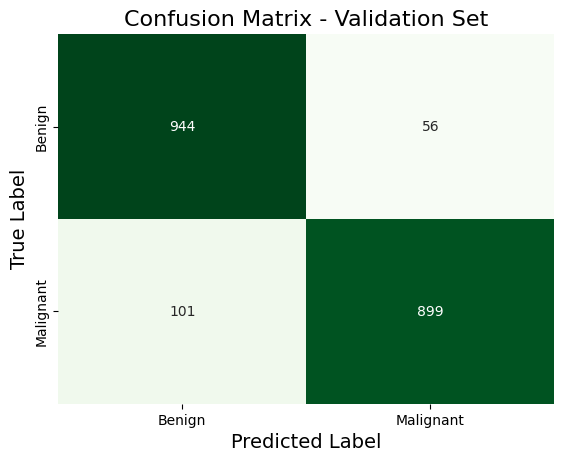

In [14]:
model.eval()
allLabels = []
allPreds = []

with torch.no_grad():
    for inputs, labels in valLoader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.unsqueeze(1).float()

        outputs = model(inputs)
        predictions = (torch.sigmoid(outputs) > 0.5).float()

        allLabels.extend(labels.cpu().numpy())
        allPreds.extend(predictions.cpu().numpy())

allLabels = np.array(allLabels)
allPreds = np.array(allPreds)

matrix = confusion_matrix(allLabels, allPreds)

sns.heatmap(matrix, annot = True, fmt = 'd', cmap = 'Greens', xticklabels = valData.classes, yticklabels = valData.classes, cbar = False)
plt.title('Confusion Matrix - Validation Set', fontsize = 16)
plt.xlabel('Predicted Label', fontsize = 14)
plt.ylabel('True Label', fontsize = 14)
plt.show()

In [15]:
model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [16]:
model.to(device)

ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTAttention(
          (attention): ViTSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUActivation(

In [17]:
model.classifier = nn.Linear(model.config.hidden_size, 2)


In [18]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10):
    for images, labels in trainLoader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()



OutOfMemoryError: CUDA out of memory. Tried to allocate 592.00 MiB (GPU 0; 14.75 GiB total capacity; 14.03 GiB already allocated; 167.06 MiB free; 14.43 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF